#### ***Lab 0: Introduction to ADQL and Gaia Data***
#### **ASTRON 128 – Fall 2024**
#### *Vardaan Tekriwal*

---

#### **Imports and Caching**

The caching function has the following functionality:

"""
    Execute a Gaia query and parse the results into a pandas DataFrame.
    Save the results to a file for future use. If no filename is provided,
    it guesses the output filename based on the query.
    
    Parameters:
    - query: str, the query to execute
    - local_filename: str, optional, the filename to save or load the results
    - verbose: bool, optional, whether to print verbose output
    - overwrite: bool, optional, whether to overwrite the existing file
    
    Returns: dataframe
    """

In [165]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astropy.table import Table
from read_mist_models import ISOCMD
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
def get_and_parse_cached_gaia_query(query, local_filename=None, verbose=True, overwrite=False):
    
    # Create a default filename based on a hash of the query if not provided
    if local_filename is None:
        local_filename = f"gaia_query_{hash(query)}.csv"
        
    if not os.path.exists(local_filename) or overwrite:
        start = time.time()
        job = Gaia.launch_job(query)
        results = job.get_results()
        
        df = results.to_pandas()
        df.to_csv(local_filename, index=False)
        
        if verbose:
            print(f"Wrote the file {local_filename} to disk", flush=True)
            print(f"  Total time: {time.time() - start:0.3} sec")
    else:
        start = time.time()
        if verbose:
            print(f"Reading the file {local_filename} from disk")
        df = pd.read_csv(local_filename)
        if verbose:
            print(f"  Total time: {time.time() - start:0.3} sec")
    return df


---

#### **Discussion on Factors Leading to Bad Astrometry and the Role of Implemented Cuts**

#### Astrometric Measurement Errors
- **Poor Signal-to-Noise Ratio (SNR)**: Stars that are faint or have low signal relative to the background noise can have poorly constrained astrometric parameters.
- **Crowded Fields**: In regions with many nearby stars, the overlapping of stellar images can lead to incorrect measurements of position and motion.
- **Instrumental Limitations**: Limitations in the telescope's resolution or sensor sensitivity can introduce systematic errors in astrometry.
- **Temporal Coverage**: Limited observational periods or fewer measurements can result in less reliable astrometric data.

#### Role of Parallax Over Error Cut: `parallax_over_error > 10`
   - **Issue Addressed**: Parallax measurements are subject to uncertainty, particularly for distant or faint stars where the parallax angle is very small.
   - **How the Cut Helps**: By requiring `parallax_over_error > 10`, we ensure that only stars with well-determined parallaxes are included. This means the distance measurements for these stars are reliable, which is crucial for accurately placing them on the Color-Magnitude Diagram (CMD).

#### Impact of Visibility Periods on Astrometric Quality: `visibility_periods_used > 8`
   - **Issue Addressed**: Stars that have been observed fewer times may have less reliable astrometric solutions, as there is insufficient data to accurately determine their positions and motions.
   - **How the Cut Helps**: Setting a threshold of `visibility_periods_used > 8` ensures that only stars with ample observational data are included. This reduces the risk of including stars with poor astrometric fits due to insufficient data points.

#### Proper Motion Uncertainty and Crowded Fields
   - **Issue Addressed**: In crowded fields, where many stars are close together, proper motion measurements can be contaminated by nearby stars, leading to incorrect values.
   - **How the Proper Motion Cuts Help**: By applying specific ranges for based on the expected values for the clusters, the filtering process excludes stars with anomalous proper motions that do not match the cluster’s kinematic signature. This helps isolate true cluster members from field stars and reduces the influence of measurement errors caused by crowding.

#### BP/RP Excess Factor and Photometric Quality
   - **Issue Addressed**: The BP/RP excess factor is a photometric quality indicator that can flag issues like contamination from nearby sources, which can affect astrometric solutions as well.
   - **How the Cut Helps**: The BP/RP excess factor filters are designed to remove stars with problematic photometry, which often correlates with poor astrometric data. By filtering out stars with excess BP/RP factors, the dataset retains only those stars with clean photometric and astrometric data, leading to more reliable CMDs.

#### Astrometric Chi-Square (`sqrt_chi2`) and the Fit of the Astrometric Model
   - **Issue Addressed**: The chi-square value of the astrometric solution indicates how well the observed positions fit the astrometric model. A high chi-square value suggests a poor fit, which could be due to various factors, including instrumental noise, unresolved binary stars, or background sources.
   - **How the Cut Helps**: The `sqrt_chi2` filter is used to exclude stars with poor astrometric fits. By applying a dynamic threshold based on the star's magnitude, this cut removes stars with large residuals in their astrometric measurements, ensuring that only stars with well-fitted astrometric models are included in the analysis.


#### References
- Babusiaux et al. 2018 (arxiv: 1804.09378)
- “An Introduction to Modern Astrophysics” by Bradley W. Carroll & Dale A. Ostlie

---

#### **Hyades Cluster**

##### Parallax > 20: 
- This condition filters for stars that are relatively close, with a parallax greater than 20 milliarcseconds.

##### RA BETWEEN 50 AND 150: 
- This selects stars within the right ascension range of 50 to 150 degrees, encompassing the spatial locality of the Hyades cluster.

##### Dec BETWEEN 5 AND 35: 
- This selects stars within the declination range of 5 to 35 degrees, ensuring coverage of the cluster's region on the sky.

##### Proper Motion Filters: `pmra` and `pmdec`
- The specific ranges for `pmra` (74 to 140 mas/year) and `pmdec` (-40 to -20 mas/year) were chosen based on the expected proper motion of the Hyades cluster. 
- Stars in a cluster generally move together through space, whereas field stars typically have different motions.


#### References
- Lodieu et al. 2018 (arxiv: 1901.07534)


In [3]:
query_hyades = """
SELECT * FROM gaiadr3.gaia_source
WHERE
    parallax > 20 AND
    ra BETWEEN 50 AND 150 AND
    dec BETWEEN 5 AND 35
    """

hyades_df = get_and_parse_cached_gaia_query(query_hyades, "hyades_gaia_data.csv")

Reading the file hyades_gaia_data.csv from disk
  Total time: 0.0415 sec


In [4]:
sqrt_chi2 = np.sqrt(hyades_df['astrometric_chi2_al'] / (hyades_df['astrometric_n_good_obs_al'] - 5))

filtered_hyades_df = hyades_df[
    (hyades_df['pmra'] > 74) & (hyades_df['pmra'] < 140) &
    (hyades_df['pmdec'] > -40) & (hyades_df['pmdec'] < -20) &
    (hyades_df['parallax_over_error'] > 10) &
    (hyades_df['visibility_periods_used'] > 8) &
    (hyades_df['phot_bp_rp_excess_factor'] > 1.0 + 0.015 * (hyades_df['phot_bp_mean_mag'] - hyades_df['phot_rp_mean_mag'])**2) &
    (hyades_df['phot_bp_rp_excess_factor'] < 1.3 + 0.06 * (hyades_df['phot_bp_mean_mag'] - hyades_df['phot_rp_mean_mag'])**2) &
    (hyades_df['phot_g_mean_flux_over_error'] > 50) &
    (hyades_df['phot_rp_mean_flux_over_error'] > 20) &
    (hyades_df['phot_bp_mean_flux_over_error'] > 20) &
    (sqrt_chi2 < (1.2 * np.maximum(1, np.exp(-0.2 * (hyades_df['phot_g_mean_mag'] - 19.5)))))
]

In [5]:
position_filtered_hyades_df = hyades_df[
    (hyades_df['pmra'] > 74) & (hyades_df['pmra'] < 140) &
    (hyades_df['pmdec'] > -40) & (hyades_df['pmdec'] < -20)
].copy()

error_filtered_hyades_df = hyades_df[
    (hyades_df['parallax_over_error'] > 10) &
    (hyades_df['visibility_periods_used'] > 8) &
    (hyades_df['phot_bp_rp_excess_factor'] > 1.0 + 0.015 * (hyades_df['phot_bp_mean_mag'] - hyades_df['phot_rp_mean_mag'])**2) &
    (hyades_df['phot_bp_rp_excess_factor'] < 1.3 + 0.06 * (hyades_df['phot_bp_mean_mag'] - hyades_df['phot_rp_mean_mag'])**2) &
    (hyades_df['phot_g_mean_flux_over_error'] > 50) &
    (hyades_df['phot_rp_mean_flux_over_error'] > 20) &
    (hyades_df['phot_bp_mean_flux_over_error'] > 20) &
    (sqrt_chi2 < (1.2 * np.maximum(1, np.exp(-0.2 * (hyades_df['phot_g_mean_mag'] - 19.5)))))
].copy()

In [6]:
print(f"Number of stars before filtering: {len(hyades_df)}")
print(f"Number of stars after filtering: {len(filtered_hyades_df)}")

Number of stars before filtering: 2000
Number of stars after filtering: 164


In [7]:
# List of essential columns
essential_columns = [
    'ra', 'dec', 'bp_rp', 
    'parallax', 'parallax_over_error',
    'pmra', 'pmdec',
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
    'visibility_periods_used',
    'phot_bp_rp_excess_factor',
    'astrometric_excess_noise',
    'astrometric_chi2_al', 'astrometric_n_good_obs_al'
]

filtered_hyades_df = filtered_hyades_df[essential_columns]
position_filtered_hyades_df = position_filtered_hyades_df[essential_columns]
error_filtered_hyades_df = error_filtered_hyades_df[essential_columns]

filtered_hyades_df.columns

Index(['ra', 'dec', 'bp_rp', 'parallax', 'parallax_over_error', 'pmra',
       'pmdec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'visibility_periods_used', 'phot_bp_rp_excess_factor',
       'astrometric_excess_noise', 'astrometric_chi2_al',
       'astrometric_n_good_obs_al'],
      dtype='object')

In [8]:
filtered_hyades_df.loc[:, 'abs_mag'] = filtered_hyades_df['phot_g_mean_mag'] - 5 * np.log10(1000 / filtered_hyades_df['parallax']) + 5
error_filtered_hyades_df.loc[:, 'abs_mag'] = error_filtered_hyades_df['phot_g_mean_mag'] - 5 * np.log10(1000 / error_filtered_hyades_df['parallax']) + 5
position_filtered_hyades_df.loc[:, 'abs_mag'] = position_filtered_hyades_df['phot_g_mean_mag'] - 5 * np.log10(1000 / position_filtered_hyades_df['parallax']) + 5

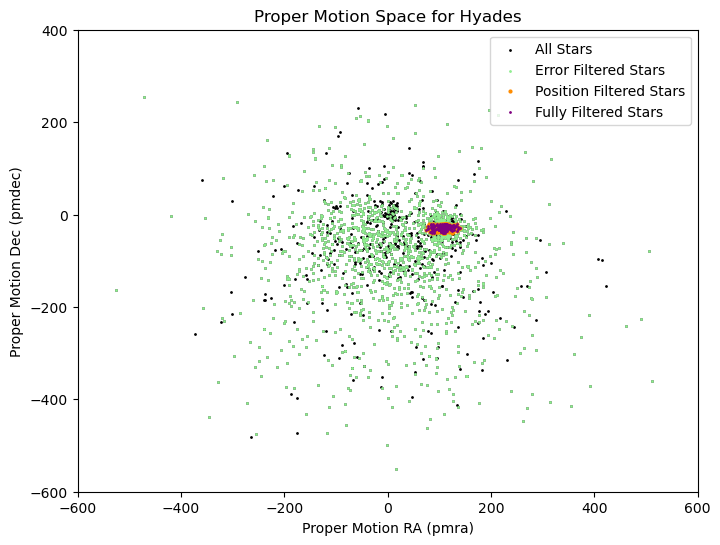

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(hyades_df['pmra'], hyades_df['pmdec'], s=1, color='black', label='All Stars')
plt.scatter(error_filtered_hyades_df['pmra'], error_filtered_hyades_df['pmdec'], s=1, color='lightgreen', label='Error Filtered Stars')
plt.scatter(position_filtered_hyades_df['pmra'], position_filtered_hyades_df['pmdec'], s=4, color='darkorange', label='Position Filtered Stars')
plt.scatter(filtered_hyades_df['pmra'], filtered_hyades_df['pmdec'], s=1, color='purple', label='Fully Filtered Stars')
plt.xlabel('Proper Motion RA (pmra)')
plt.ylabel('Proper Motion Dec (pmdec)')
plt.title('Proper Motion Space for Hyades')
plt.ylim((-600, 400))
plt.xlim((-600, 600))
plt.legend()
plt.show()


Since we used a rectangular cut specifically in relation to the Hyades cluster, with reference to prior literature, we see that there is a clear cluster of stars based on position only – considering that the parallax was taken care of in the selection for the sky itself. In fact, there also is a greater density of stars in the region surrounding the fully filtered stars. An observation here is that many of the stars that were within the bounds of positional filters were errors, as they fell within the orange cluster. 

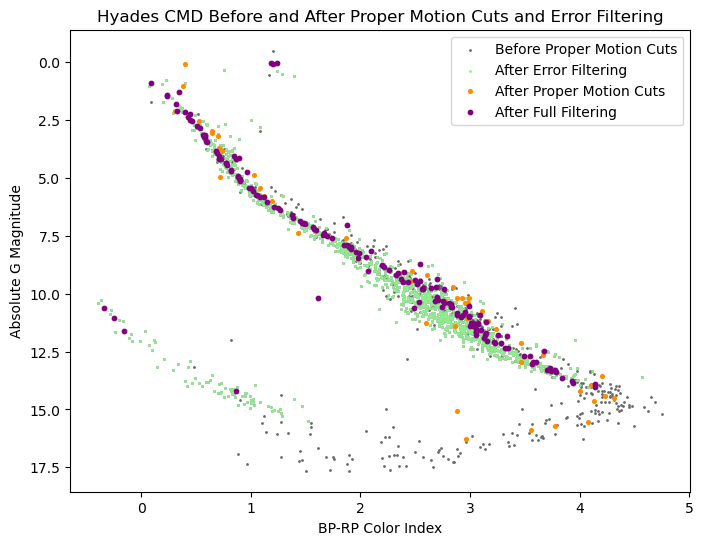

In [11]:
plt.figure(figsize=(8, 6))

# CMD before proper motion cuts (in gray, smaller dots)
plt.scatter(hyades_df['bp_rp'], hyades_df['phot_g_mean_mag'] - 5 * np.log10(1000 / hyades_df['parallax']) + 5, s=1, color='dimgray', label='Before Proper Motion Cuts')

# CMD after error filtering (in purple, larger dots)
plt.scatter(error_filtered_hyades_df['bp_rp'], error_filtered_hyades_df['abs_mag'], s=1, color='lightgreen', label='After Error Filtering')

# CMD after position filtering (in purple, larger dots)
plt.scatter(position_filtered_hyades_df['bp_rp'], position_filtered_hyades_df['abs_mag'], s=7, color='darkorange', label='After Proper Motion Cuts')

# CMD after proper motion cuts and error filtering (in purple, larger dots)
plt.scatter(filtered_hyades_df['bp_rp'], filtered_hyades_df['abs_mag'], s=10, color='purple', label='After Full Filtering')

# Invert y-axis to have brighter stars at the top
plt.gca().invert_yaxis()

plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute G Magnitude')
plt.title('Hyades CMD Before and After Proper Motion Cuts and Error Filtering')
plt.legend()
plt.show()


The stars that are within the fully filtered (error and positional filtering) cuts (purple) in comparison to the background stars (grey) is cleaner. There is a more systematic, almost continuous line through the observed stars. That being said, the cuts do not disregard the stars in the cluster that are not in the Main Sequence. Stars that are in the White Dwarf Sequence (bottom left sub-cluster) and the Giant Stars Sequence (top right sub-cluster) are still within the filtered Hyades cluster. 

A rather interesting observation is that many of the stars that were considered errors (grey) were ones that, visually, would not fall into any one of the three clusters. Informally, this demonstrates the fact that the error filters used in the Babusiaux et al. 2018 paper were, in fact, effective. 

---

#### **M67 Cluster**

#### References for Cuts and Parameters
- Hendy & Rahman 2022 (DOI: 10.1080/20909977.2022.2040174)
- Reyes et al. 2024 (arXiv: 2407.03526)


In [115]:
query_m67 = """
SELECT TOP 50000 * FROM gaiadr3.gaia_source
WHERE
    parallax BETWEEN 0.9 AND 1.3 AND
    ra BETWEEN 130 AND 135 AND
    dec BETWEEN 10 AND 15
    """

m67_df = get_and_parse_cached_gaia_query(query_m67, "m67_gaia_data.csv")


Reading the file m67_gaia_data.csv from disk
  Total time: 0.223 sec


In [117]:
sqrt_chi2_m67 = np.sqrt(m67_df['astrometric_chi2_al'] / (m67_df['astrometric_n_good_obs_al'] - 5))

filtered_m67_df = m67_df[
    (m67_df['pmra'] > -10) & (m67_df['pmra'] < -5) &
    (m67_df['pmdec'] > -3) & (m67_df['pmdec'] < 1) &
    (m67_df['parallax_over_error'] > 10) &
    (m67_df['visibility_periods_used'] > 8) &
    (m67_df['phot_bp_rp_excess_factor'] > 1.0 + 0.015 * (m67_df['phot_bp_mean_mag'] - m67_df['phot_rp_mean_mag'])**2) &
    (m67_df['phot_bp_rp_excess_factor'] < 1.3 + 0.06 * (m67_df['phot_bp_mean_mag'] - m67_df['phot_rp_mean_mag'])**2) &
    (m67_df['phot_g_mean_flux_over_error'] > 50) &
    (m67_df['phot_rp_mean_flux_over_error'] > 20) &
    (m67_df['phot_bp_mean_flux_over_error'] > 20) &
    (sqrt_chi2_m67 < (1.2 * np.maximum(1, np.exp(-0.2 * (m67_df['phot_g_mean_mag'] - 19.5)))))
]


In [118]:
position_filtered_m67_df = m67_df[
    (m67_df['pmra'] > -10) & (m67_df['pmra'] < -5) &
    (m67_df['pmdec'] > -3) & (m67_df['pmdec'] < 1)
].copy()

error_filtered_m67_df = m67_df[
    (m67_df['parallax_over_error'] > 10) &
    (m67_df['visibility_periods_used'] > 8) &
    (m67_df['phot_bp_rp_excess_factor'] > 1.0 + 0.015 * (m67_df['phot_bp_mean_mag'] - m67_df['phot_rp_mean_mag'])**2) &
    (m67_df['phot_bp_rp_excess_factor'] < 1.3 + 0.06 * (m67_df['phot_bp_mean_mag'] - m67_df['phot_rp_mean_mag'])**2) &
    (m67_df['phot_g_mean_flux_over_error'] > 50) &
    (m67_df['phot_rp_mean_flux_over_error'] > 20) &
    (m67_df['phot_bp_mean_flux_over_error'] > 20) &
    (sqrt_chi2_m67 < (1.2 * np.maximum(1, np.exp(-0.2 * (m67_df['phot_g_mean_mag'] - 19.5)))))
].copy()

In [119]:
essential_columns = [
    'ra', 'dec', 'bp_rp', 
    'parallax', 'parallax_over_error',
    'pmra', 'pmdec',
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
    'visibility_periods_used',
    'phot_bp_rp_excess_factor',
    'astrometric_excess_noise',
    'astrometric_chi2_al', 'astrometric_n_good_obs_al'
]

filtered_m67_df = filtered_m67_df[essential_columns]
position_filtered_m67_df = position_filtered_m67_df[essential_columns]
error_filtered_m67_df = error_filtered_m67_df[essential_columns]

In [120]:
filtered_m67_df.loc[:, 'abs_mag'] = filtered_m67_df['phot_g_mean_mag'] - 5 * np.log10(1000 / filtered_m67_df['parallax']) + 5
error_filtered_m67_df.loc[:, 'abs_mag'] = error_filtered_m67_df['phot_g_mean_mag'] - 5 * np.log10(1000 / error_filtered_m67_df['parallax']) + 5
position_filtered_m67_df.loc[:, 'abs_mag'] = position_filtered_m67_df['phot_g_mean_mag'] - 5 * np.log10(1000 / position_filtered_m67_df['parallax']) + 5

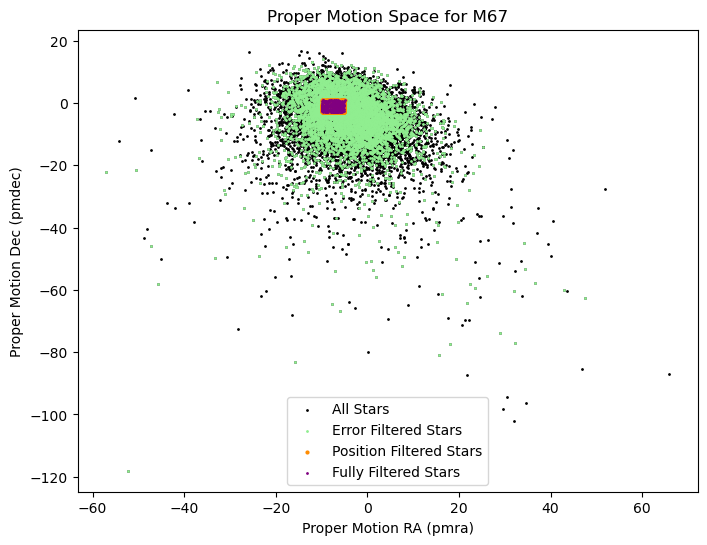

In [121]:
plt.figure(figsize=(8, 6))
plt.scatter(m67_df['pmra'], m67_df['pmdec'], s=1, color='black', label='All Stars')
plt.scatter(error_filtered_m67_df['pmra'], error_filtered_m67_df['pmdec'], s=1, color='lightgreen', label='Error Filtered Stars')
plt.scatter(position_filtered_m67_df['pmra'], position_filtered_m67_df['pmdec'], s=4, color='darkorange', label='Position Filtered Stars')
plt.scatter(filtered_m67_df['pmra'], filtered_m67_df['pmdec'], s=1, color='purple', label='Fully Filtered Stars')
plt.xlabel('Proper Motion RA (pmra)')
plt.ylabel('Proper Motion Dec (pmdec)')
plt.title('Proper Motion Space for M67')
#plt.ylim((-40, 20))
#plt.xlim((-40, 20))
plt.legend()
plt.show()

In [122]:
print(f"Number of stars before filtering: {len(m67_df)}")
print(f"Number of stars after filtering: {len(filtered_m67_df)}")

Number of stars before filtering: 18080
Number of stars after filtering: 272


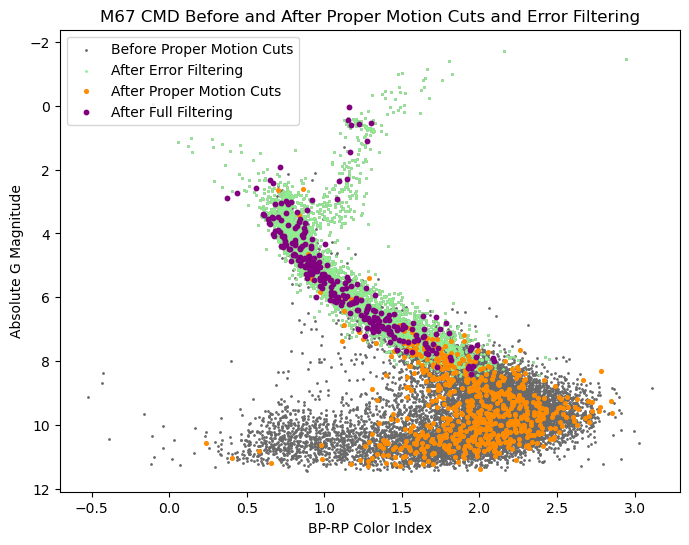

In [123]:
plt.figure(figsize=(8, 6))
plt.scatter(m67_df['bp_rp'], m67_df['phot_g_mean_mag'] - 5 * np.log10(1000 / m67_df['parallax']) + 5, s=1, color='dimgray', label='Before Proper Motion Cuts')
plt.scatter(error_filtered_m67_df['bp_rp'], error_filtered_m67_df['abs_mag'], s=1, color='lightgreen', label='After Error Filtering')
plt.scatter(position_filtered_m67_df['bp_rp'], position_filtered_m67_df['abs_mag'], s=7, color='darkorange', label='After Proper Motion Cuts')
plt.scatter(filtered_m67_df['bp_rp'], filtered_m67_df['abs_mag'], s=10, color='purple', label='After Full Filtering')

plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute G Magnitude')
plt.title('M67 CMD Before and After Proper Motion Cuts and Error Filtering')
plt.legend()
plt.show()

---

#### **NGC 6397 Cluster**

#### References for Cuts and Parameters
- Hubble 2002
- Chen et al. 2010


In [89]:
query_ngc6397 = """
SELECT TOP 50000 * FROM gaiadr3.gaia_source
WHERE
    parallax BETWEEN 0.3 AND 0.5 AND
    ra BETWEEN 262.0 AND 268.0 AND
    dec BETWEEN -56.0 AND -51.0
    """

ngc6397_df = get_and_parse_cached_gaia_query(query_ngc6397, "ngc6397_gaia_data.csv", overwrite = True)

Wrote the file ngc6397_gaia_data.csv to disk
  Total time: 1.32e+02 sec


In [107]:
sqrt_chi2_ngc6397 = np.sqrt(ngc6397_df['astrometric_chi2_al'] / (ngc6397_df['astrometric_n_good_obs_al'] - 5))

filtered_ngc6397_df = ngc6397_df[
    (ngc6397_df['pmra'] > 3) & (ngc6397_df['pmra'] < 5) &
    (ngc6397_df['pmdec'] > -10) & (ngc6397_df['pmdec'] < -5) &
    (ngc6397_df['parallax_over_error'] > 10) &
    (ngc6397_df['visibility_periods_used'] > 8) &
    (ngc6397_df['phot_bp_rp_excess_factor'] > 1.0 + 0.015 * (ngc6397_df['phot_bp_mean_mag'] - ngc6397_df['phot_rp_mean_mag'])**2) &
    (ngc6397_df['phot_bp_rp_excess_factor'] < 1.3 + 0.06 * (ngc6397_df['phot_bp_mean_mag'] - ngc6397_df['phot_rp_mean_mag'])**2) &
    (ngc6397_df['phot_g_mean_flux_over_error'] > 50) &
    (ngc6397_df['phot_rp_mean_flux_over_error'] > 20) &
    (ngc6397_df['phot_bp_mean_flux_over_error'] > 20) &
    (sqrt_chi2_ngc6397 < (1.2 * np.maximum(1, np.exp(-0.2 * (ngc6397_df['phot_g_mean_mag'] - 19.5)))))
]


In [108]:
position_filtered_ngc6397_df = ngc6397_df[
    (ngc6397_df['pmra'] > 3) & (ngc6397_df['pmra'] < 5) &
    (ngc6397_df['pmdec'] > -10) & (ngc6397_df['pmdec'] < -5)
].copy()

error_filtered_ngc6397_df = ngc6397_df[
    (ngc6397_df['parallax_over_error'] > 10) &
    (ngc6397_df['visibility_periods_used'] > 8) &
    (ngc6397_df['phot_bp_rp_excess_factor'] > 1.0 + 0.015 * (ngc6397_df['phot_bp_mean_mag'] - ngc6397_df['phot_rp_mean_mag'])**2) &
    (ngc6397_df['phot_bp_rp_excess_factor'] < 1.3 + 0.06 * (ngc6397_df['phot_bp_mean_mag'] - ngc6397_df['phot_rp_mean_mag'])**2) &
    (ngc6397_df['phot_g_mean_flux_over_error'] > 50) &
    (ngc6397_df['phot_rp_mean_flux_over_error'] > 20) &
    (ngc6397_df['phot_bp_mean_flux_over_error'] > 20) &
    (sqrt_chi2_ngc6397 < (1.2 * np.maximum(1, np.exp(-0.2 * (ngc6397_df['phot_g_mean_mag'] - 19.5)))))
].copy()

In [109]:
essential_columns = [
    'ra', 'dec', 'bp_rp', 
    'parallax', 'parallax_over_error',
    'pmra', 'pmdec',
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
    'visibility_periods_used',
    'phot_bp_rp_excess_factor',
    'astrometric_excess_noise',
    'astrometric_chi2_al', 'astrometric_n_good_obs_al'
]

filtered_ngc6397_df = filtered_ngc6397_df[essential_columns]
position_filtered_ngc6397_df = position_filtered_ngc6397_df[essential_columns]
error_filtered_ngc6397_df = error_filtered_ngc6397_df[essential_columns]

In [110]:
filtered_ngc6397_df.loc[:, 'abs_mag'] = filtered_ngc6397_df['phot_g_mean_mag'] - 5 * np.log10(1000 / filtered_ngc6397_df['parallax']) + 5
error_filtered_ngc6397_df.loc[:, 'abs_mag'] = error_filtered_ngc6397_df['phot_g_mean_mag'] - 5 * np.log10(1000 / error_filtered_ngc6397_df['parallax']) + 5
position_filtered_ngc6397_df.loc[:, 'abs_mag'] = position_filtered_ngc6397_df['phot_g_mean_mag'] - 5 * np.log10(1000 / position_filtered_ngc6397_df['parallax']) + 5

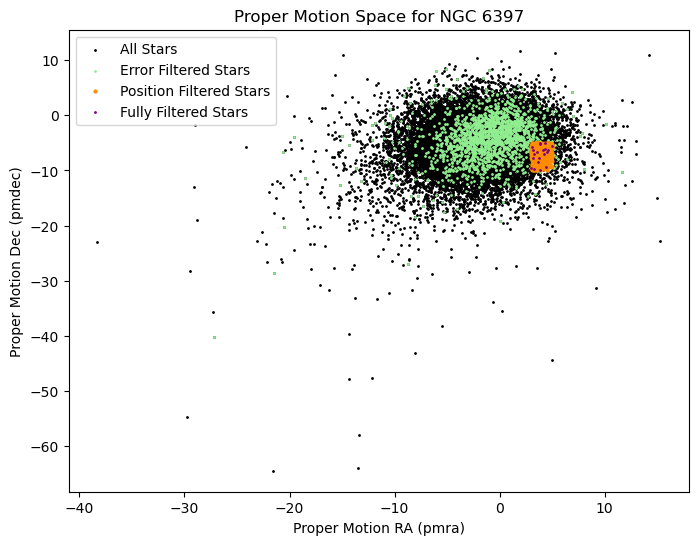

In [111]:
plt.figure(figsize=(8, 6))
plt.scatter(ngc6397_df['pmra'], ngc6397_df['pmdec'], s=1, color='black', label='All Stars')
plt.scatter(error_filtered_ngc6397_df['pmra'], error_filtered_ngc6397_df['pmdec'], s=1, color='lightgreen', label='Error Filtered Stars')
plt.scatter(position_filtered_ngc6397_df['pmra'], position_filtered_ngc6397_df['pmdec'], s=4, color='darkorange', label='Position Filtered Stars')
plt.scatter(filtered_ngc6397_df['pmra'], filtered_ngc6397_df['pmdec'], s=1, color='purple', label='Fully Filtered Stars')
plt.xlabel('Proper Motion RA (pmra)')
plt.ylabel('Proper Motion Dec (pmdec)')
plt.title('Proper Motion Space for NGC 6397')
plt.legend()
plt.show()

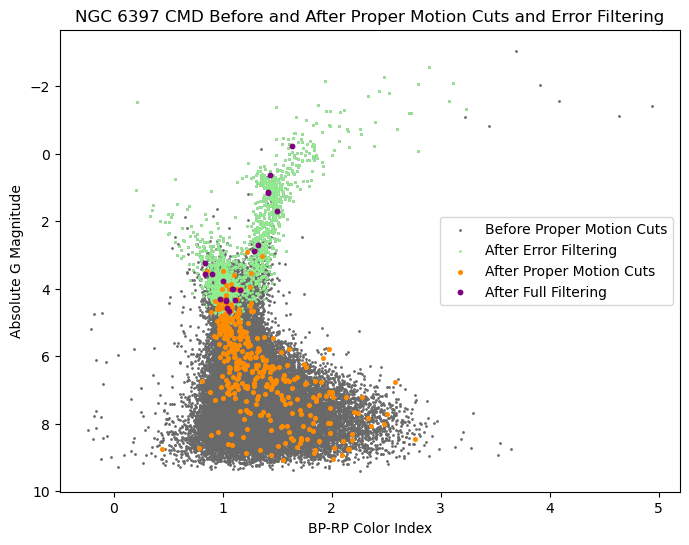

In [114]:
plt.figure(figsize=(8, 6))
plt.scatter(ngc6397_df['bp_rp'], ngc6397_df['phot_g_mean_mag'] - 5 * np.log10(1000 / ngc6397_df['parallax']) + 5, s=1, color='dimgray', label='Before Proper Motion Cuts')
plt.scatter(error_filtered_ngc6397_df['bp_rp'], error_filtered_ngc6397_df['abs_mag'], s=1, color='lightgreen', label='After Error Filtering')
plt.scatter(position_filtered_ngc6397_df['bp_rp'], position_filtered_ngc6397_df['abs_mag'], s=7, color='darkorange', label='After Proper Motion Cuts')
plt.scatter(filtered_ngc6397_df['bp_rp'], filtered_ngc6397_df['abs_mag'], s=10, color='purple', label='After Full Filtering')

# Invert y-axis to have brighter stars at the top
plt.gca().invert_yaxis()

plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute G Magnitude')
plt.title('NGC 6397 CMD Before and After Proper Motion Cuts and Error Filtering')
plt.legend()
plt.show()

---

#### Identifying Stellar Evolution Phases

As alluded to in the previous section regarding clustering, each isochrone represents a track of stellar evolution for a given age and metallicity. Different regions of the isochrone correspond to various phases of stellar evolution. Namely:

1. Main Sequence:
- The bulk of stars will fall along the main sequence, where stars burn hydrogen in their cores.
- This is typically the longest phase in a star's life.
- On the CMD, the main sequence is the diagonal portion of the isochrone, typically from hot, blue stars (upper left) to cool, red stars (lower right).

2. Turnoff Point
- The turnoff point occurs where stars start leaving the main sequence as they run out of hydrogen in their cores and move towards the next phase of evolution.
- The position of the turnoff helps to estimate the cluster’s age, since older clusters will have turnoff points at redder (lower) positions on the CMD.

3. Red Giants
- Stars that have exhausted their hydrogen cores expand into subgiants and then evolve into red giants.
- The red giant branch is the nearly vertical, redward extension of the isochrone (i.e. top right)

4. White Dwarfs
- Some stars may have evolved into white dwarfs. These stars would appear faint and blue in the lower-left corner of the CMD.

---

#### Hyades Cluster

In [169]:
# Load the isochrone files for various metallicities
iso_fe_h_0_cmd = ISOCMD('hyades_MIST/isochrone_FeH_0.cmd')
iso_fe_h_015_cmd = ISOCMD('hyades_MIST/isochrone_FeH_015.cmd')
iso_fe_h_03_cmd = ISOCMD('hyades_MIST/isochrone_FeH_03.cmd')

# Function to plot isochrones
def plot_isochrone(iso_cmd, log_age, color, label):
    age_index = iso_cmd.age_index(log_age)
    gaia_g = iso_cmd.isocmds[age_index]['Gaia_G_EDR3']
    gaia_bp = iso_cmd.isocmds[age_index]['Gaia_BP_EDR3']
    gaia_rp = iso_cmd.isocmds[age_index]['Gaia_RP_EDR3']
    bp_rp_color = gaia_bp - gaia_rp
    plt.plot(bp_rp_color, gaia_g, color=color, label=label)



Reading in: hyades_MIST/isochrone_FeH_0.cmd
Reading in: hyades_MIST/isochrone_FeH_015.cmd
Reading in: hyades_MIST/isochrone_FeH_03.cmd


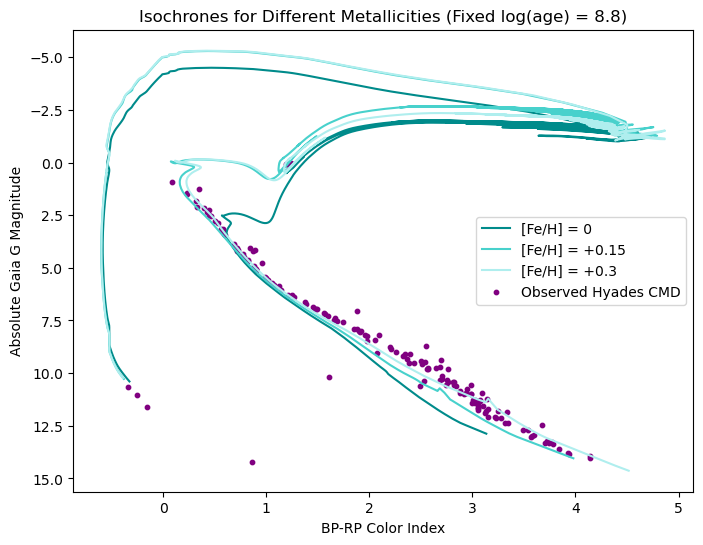

In [272]:
### Plot 1: Varying Metallicities (Fixed log(age) = 8.8)
plt.figure(figsize=(8, 6))

# Overplot isochrones for different metallicities, fixed log(age) = 8.8
plot_isochrone(iso_fe_h_0_cmd, 9.5, 'darkcyan', '[Fe/H] = 0')
plot_isochrone(iso_fe_h_015_cmd, 8.8, 'mediumturquoise', '[Fe/H] = +0.15')
plot_isochrone(iso_fe_h_03_cmd, 8.8, 'paleturquoise', '[Fe/H] = +0.3')

# Plot the observed Hyades CMD for comparison
plt.scatter(filtered_hyades_df['bp_rp'], filtered_hyades_df['abs_mag'], s=10, color='purple', label='Observed Hyades CMD')

# Invert y-axis and add labels
plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('Isochrones for Different Metallicities (Fixed log(age) = 8.8)')
plt.legend()
plt.show()



From observation, the metallicity of +0.3 fits the CMD most optimally. This information is incorporated in the attempt to approximate the age of the cluster. The metallicity is fixed, and the ischrone that is most "fine-tuned" to the data is selected. The same procedure is followed for the other clusters.

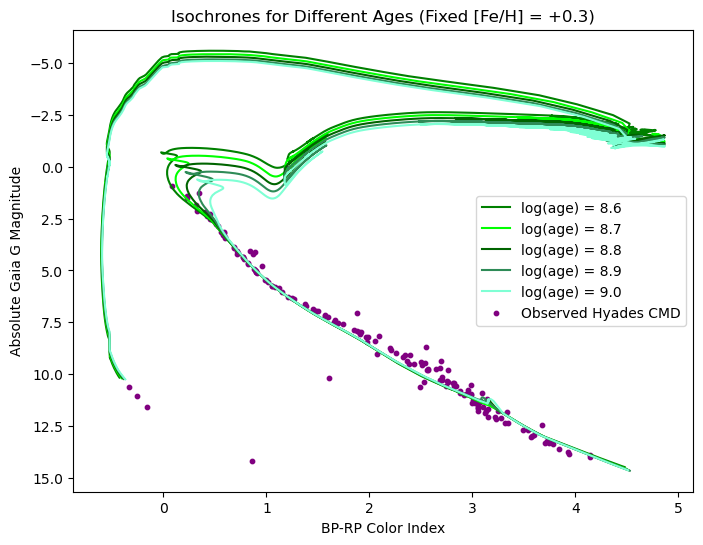

In [164]:
plt.figure(figsize=(8, 6))

plot_isochrone(iso_fe_h_03_cmd, 8.6, 'green', 'log(age) = 8.6')
plot_isochrone(iso_fe_h_03_cmd, 8.7, 'lime', 'log(age) = 8.7')
plot_isochrone(iso_fe_h_03_cmd, 8.8, 'darkgreen', 'log(age) = 8.8')
plot_isochrone(iso_fe_h_03_cmd, 8.9, 'seagreen', 'log(age) = 8.9')
plot_isochrone(iso_fe_h_03_cmd, 9.0, 'aquamarine', 'log(age) = 9.0')

plt.scatter(filtered_hyades_df['bp_rp'], filtered_hyades_df['abs_mag'], s=10, color='purple', label='Observed Hyades CMD')

plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('Isochrones for Different Ages (Fixed [Fe/H] = +0.3)')
plt.legend()
plt.show()


As defined above, the turnoff point should yield clues regarding the most optimal age. Howwever, there is still ambiguity regarding the optimality of the isochrone since different observations yield different interpretations. 

Therefore, a minimax method is used to select the optimal age – 10^(8.8). As determined from the previous plot, the optimal metallicity is +0.30

##### Identifying Potential Binary Stars

1. Binary Main Sequence:
- Binaries will appear above and to the left of the main sequence, forming a "parallel sequence" that is brighter than the standard main sequence.
- This is because the combined light of two main-sequence stars is brighter than the light from one.


2. Check for Overluminous Stars:
- Look for stars that are slightly above the main sequence track of the best-fit isochrone.
- These could be unresolved binaries where both stars are contributing to the observed brightness.

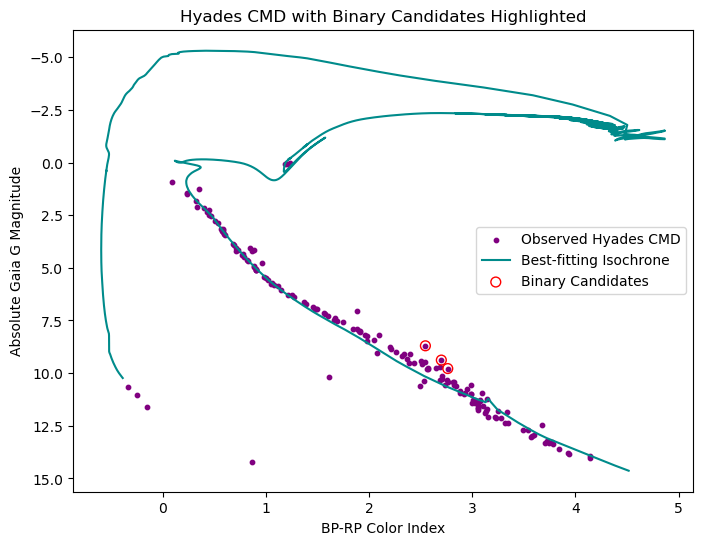

In [210]:
# Load the best-fitting isochrone, e.g., [Fe/H] = +0.3, log(age) = 8.8
best_isochron_cmd = iso_fe_h_03_cmd.isocmds[iso_fe_h_03_cmd.age_index(8.8)]
iso_bp_rp = best_isochron_cmd['Gaia_BP_EDR3'] - best_isochron_cmd['Gaia_RP_EDR3']
iso_gaia_g = best_isochron_cmd['Gaia_G_EDR3']

# Interpolate the isochrone to get Gaia G magnitude for observed BP-RP color
isochrone_interp = interp1d(iso_bp_rp, iso_gaia_g, bounds_error=False, fill_value="extrapolate")

# Calculate the expected isochrone magnitudes for the observed stars
observed_bp_rp = filtered_hyades_df['bp_rp']
expected_gaia_g = isochrone_interp(observed_bp_rp)

# Identify binary candidates: stars significantly brighter than the isochrone
# Set a threshold for 'significantly brighter', for example, 0.75 magnitudes brighter
binary_threshold = 0.75
binary_candidates = filtered_hyades_df[filtered_hyades_df['abs_mag'] < (expected_gaia_g - binary_threshold)]

# Plot the CMD with the best-fitting isochrone
plt.figure(figsize=(8, 6))

# Plot observed CMD
plt.scatter(filtered_hyades_df['bp_rp'], filtered_hyades_df['abs_mag'], s=10, color='purple', label='Observed Hyades CMD')

# Plot the best-fitting isochrone
plt.plot(iso_bp_rp, iso_gaia_g, color='darkcyan', label='Best-fitting Isochrone')

# Highlight potential binary systems (stars significantly brighter than the isochrone)
plt.scatter(binary_candidates['bp_rp'], binary_candidates['abs_mag'], s=50, facecolors='none', edgecolors='red', label='Binary Candidates')

# Invert y-axis for CMD
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('Hyades CMD with Binary Candidates Highlighted')

# Add legend
plt.legend()

# Show plot
plt.show()


We identify potential binary star systems by selecting observations that are significantly brighter than expected based on the isochrone. According to the graph, we also see that using the threshold value of 1.75x brighter than the expected yields yields three observations that seem to follow a 'parallel sequence' towards the top of the main sequence. In essence, our observations are in agreement with both of the theoretical nodes: the stars are significantly brighter than expected, and they seem to follow another sequence.

---

#### M67 Cluster

In [302]:
iso_fe_h_0_cmd = ISOCMD('M67_MIST/isochrone_FeH_0.cmd')       
iso_fe_h_01_cmd = ISOCMD('M67_MIST/isochrone_FeH_01.cmd')     
iso_fe_h_02_cmd = ISOCMD('M67_MIST/isochrone_FeH_02.cmd')     

Reading in: M67_MIST/isochrone_FeH_0.cmd
Reading in: M67_MIST/isochrone_FeH_01.cmd
Reading in: M67_MIST/isochrone_FeH_02.cmd


The requested age is outside the range. Try between 9.4 and 9.6


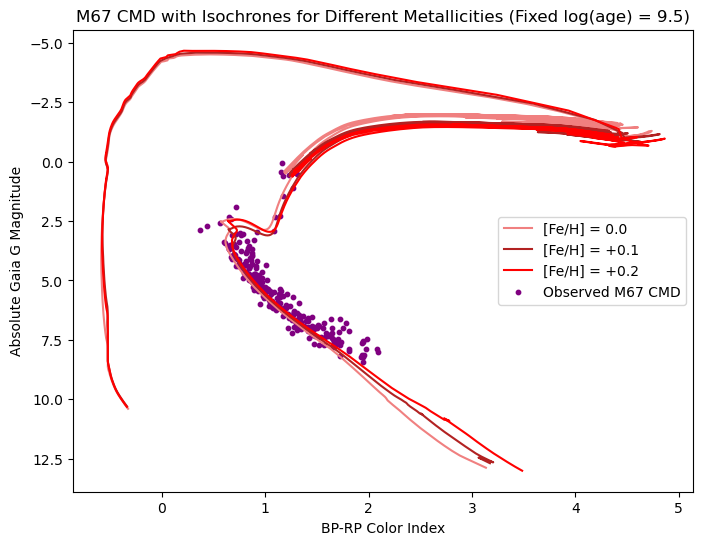

In [303]:
plt.figure(figsize=(8, 6))

# Overplot isochrones for different metallicities, fixed log(age) = 9.5
plot_isochrone(iso_fe_h_0_cmd, 9.5, 'lightcoral', '[Fe/H] = 0.0')
plot_isochrone(iso_fe_h_01_cmd, 10.1, 'firebrick', '[Fe/H] = +0.1')
plot_isochrone(iso_fe_h_02_cmd, 9.5, 'red', '[Fe/H] = +0.2')

# Plot the observed CMD for M67 (replace `filtered_m67_df` with your data)
plt.scatter(filtered_m67_df['bp_rp'], filtered_m67_df['abs_mag'], s=10, color='purple', label='Observed M67 CMD')

# Invert y-axis
plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('M67 CMD with Isochrones for Different Metallicities (Fixed log(age) = 9.5)')
plt.legend()
plt.show()


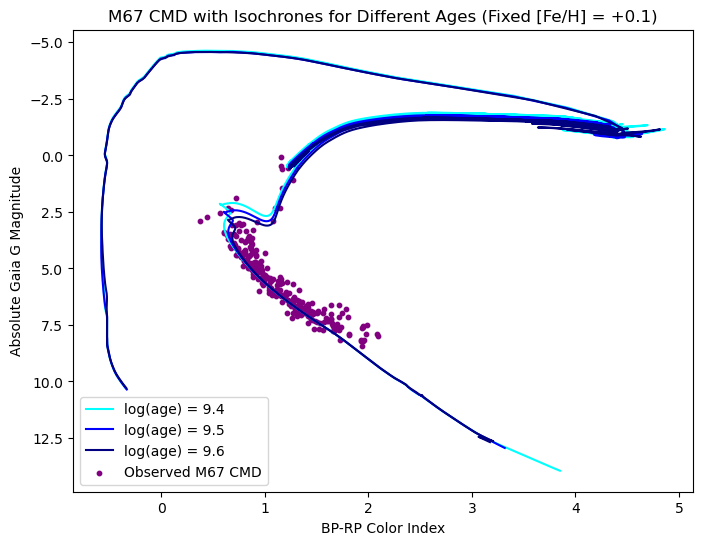

In [304]:
plt.figure(figsize=(8, 6))

# Overplot isochrones for different ages, fixed [Fe/H] = +0.1
plot_isochrone(iso_fe_h_01_cmd, 9.4, 'cyan', 'log(age) = 9.4')
plot_isochrone(iso_fe_h_01_cmd, 9.5, 'blue', 'log(age) = 9.5')
plot_isochrone(iso_fe_h_01_cmd, 9.6, 'navy', 'log(age) = 9.6')

# Plot observed CMD again
plt.scatter(filtered_m67_df['bp_rp'], filtered_m67_df['abs_mag'], s=10, color='purple', label='Observed M67 CMD')

# Invert y-axis
plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('M67 CMD with Isochrones for Different Ages (Fixed [Fe/H] = +0.1)')
plt.legend()
plt.show()

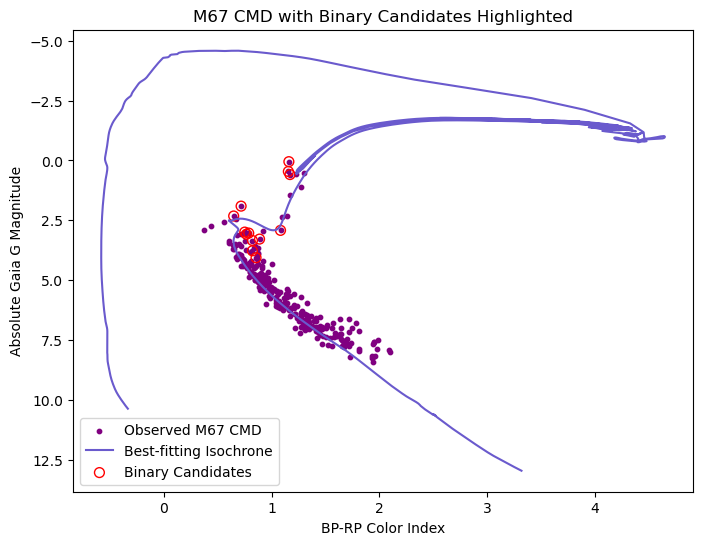

In [308]:
# Interpolate the best-fitting isochrone to get Gaia G magnitudes for observed BP-RP colors
best_isochron_cmd = iso_fe_h_01_cmd.isocmds[iso_fe_h_01_cmd.age_index(9.5)]  
iso_bp_rp = best_isochron_cmd['Gaia_BP_EDR3'] - best_isochron_cmd['Gaia_RP_EDR3']
iso_gaia_g = best_isochron_cmd['Gaia_G_EDR3']

# Interpolate the isochrone
isochrone_interp = interp1d(iso_bp_rp, iso_gaia_g, bounds_error=False, fill_value="extrapolate")

# Calculate the expected isochrone magnitudes for the observed stars
observed_bp_rp = filtered_m67_df['bp_rp']
expected_gaia_g = isochrone_interp(observed_bp_rp)

# Identify binary candidates: stars significantly brighter than the isochrone
binary_threshold = 0.75 
binary_candidates = filtered_m67_df[filtered_m67_df['abs_mag'] < (expected_gaia_g - binary_threshold)]

# Plot the CMD with the best-fitting isochrone and binary candidates
plt.figure(figsize=(8, 6))

# Plot observed CMD
plt.scatter(filtered_m67_df['bp_rp'], filtered_m67_df['abs_mag'], s=10, color='purple', label='Observed M67 CMD')

# Plot the best-fitting isochrone
plt.plot(iso_bp_rp, iso_gaia_g, color='slateblue', label='Best-fitting Isochrone')

# Highlight potential binary systems
plt.scatter(binary_candidates['bp_rp'], binary_candidates['abs_mag'], s=50, facecolors='none', edgecolors='red', label='Binary Candidates')

# Invert y-axis for CMD
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('M67 CMD with Binary Candidates Highlighted')

# Add legend
plt.legend()

# Show plot
plt.show()

The optimal isochrone yields that the metallicity is +0.1, and the log(age) is 9.5.

---

#### NGC 6397

In [313]:
iso_fe_h_neg2_cmd = ISOCMD('NGC_MIST/isochrone_FeH_neg2.cmd')   
iso_fe_h_neg15_cmd = ISOCMD('NGC_MIST/isochrone_FeH_neg15.cmd') 
iso_fe_h_neg1_cmd = ISOCMD('NGC_MIST/isochrone_FeH_neg1.cmd') 
iso_fe_h_01_cmd = ISOCMD('NGC_MIST/isochrone_FeH_01.cmd') 

Reading in: NGC_MIST/isochrone_FeH_neg2.cmd
Reading in: NGC_MIST/isochrone_FeH_neg15.cmd
Reading in: NGC_MIST/isochrone_FeH_neg1.cmd
Reading in: NGC_MIST/isochrone_FeH_01.cmd


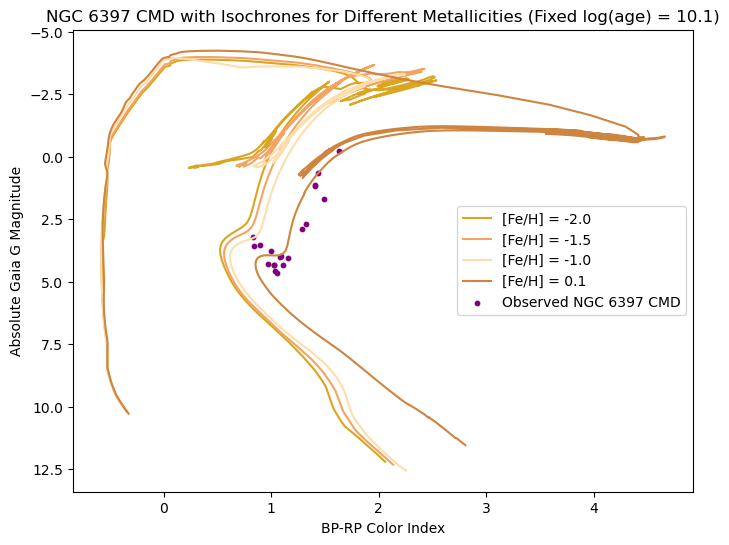

In [314]:
plt.figure(figsize=(8, 6))

# Overplot isochrones for different metallicities, fixed log(age) = 10.1
plot_isochrone(iso_fe_h_neg2_cmd, 10.1, 'goldenrod', '[Fe/H] = -2.0')
plot_isochrone(iso_fe_h_neg15_cmd, 10.1, 'sandybrown', '[Fe/H] = -1.5')
plot_isochrone(iso_fe_h_neg1_cmd, 10.1, 'navajowhite', '[Fe/H] = -1.0')
plot_isochrone(iso_fe_h_01_cmd, 10.1, 'peru', '[Fe/H] = 0.1')

# Plot the observed CMD for NGC 6397 (replace `filtered_ngc6397_df` with your data)
plt.scatter(filtered_ngc6397_df['bp_rp'], filtered_ngc6397_df['abs_mag'], s=10, color='purple', label='Observed NGC 6397 CMD')

# Invert y-axis
plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('NGC 6397 CMD with Isochrones for Different Metallicities (Fixed log(age) = 10.1)')
plt.legend()
plt.show()

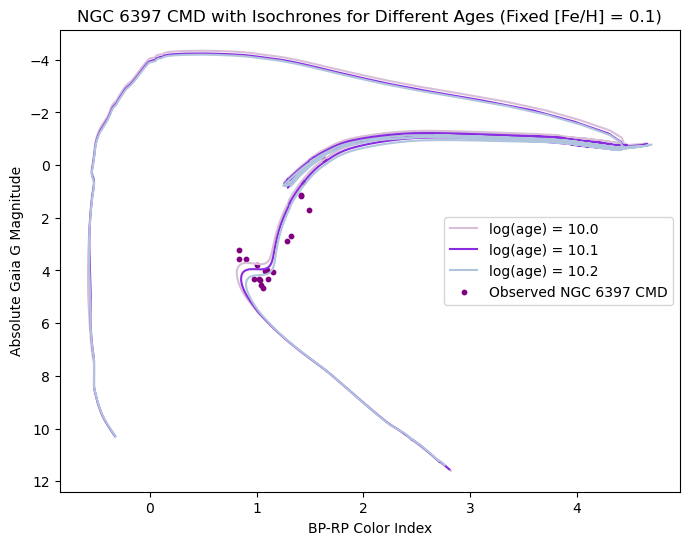

In [318]:
plt.figure(figsize=(8, 6))

# Overplot isochrones for different ages, fixed [Fe/H] = 0.1
plot_isochrone(iso_fe_h_01_cmd, 10.0, 'thistle', 'log(age) = 10.0')
plot_isochrone(iso_fe_h_01_cmd, 10.1, 'blueviolet', 'log(age) = 10.1')
plot_isochrone(iso_fe_h_01_cmd, 10.2, 'lightsteelblue', 'log(age) = 10.2')

# Plot the observed CMD for NGC 6397
plt.scatter(filtered_ngc6397_df['bp_rp'], filtered_ngc6397_df['abs_mag'], s=10, color='purple', label='Observed NGC 6397 CMD')

# Invert y-axis
plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('NGC 6397 CMD with Isochrones for Different Ages (Fixed [Fe/H] = 0.1)')
plt.legend()
plt.show()

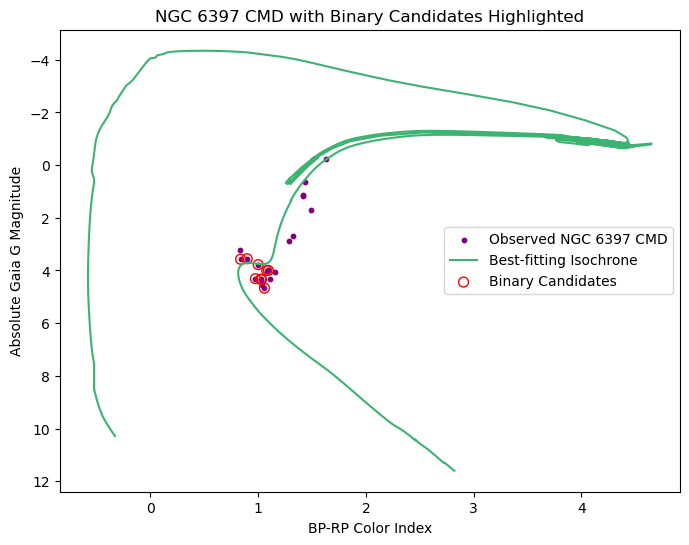

In [316]:
# Interpolate the best-fitting isochrone to get Gaia G magnitudes for observed BP-RP colors
best_isochron_cmd = iso_fe_h_01_cmd.isocmds[iso_fe_h_neg2_cmd.age_index(10.0)]
iso_bp_rp = best_isochron_cmd['Gaia_BP_EDR3'] - best_isochron_cmd['Gaia_RP_EDR3']
iso_gaia_g = best_isochron_cmd['Gaia_G_EDR3']

# Interpolate the isochrone
isochrone_interp = interp1d(iso_bp_rp, iso_gaia_g, bounds_error=False, fill_value="extrapolate")

# Calculate the expected isochrone magnitudes for the observed stars
observed_bp_rp = filtered_ngc6397_df['bp_rp']
expected_gaia_g = isochrone_interp(observed_bp_rp)

# Identify binary candidates: stars significantly brighter than the isochrone
binary_threshold = 0.75  # Adjust threshold for binary detection
binary_candidates = filtered_ngc6397_df[filtered_ngc6397_df['abs_mag'] < (expected_gaia_g - binary_threshold)]

# Plot the CMD with the best-fitting isochrone and binary candidates
plt.figure(figsize=(8, 6))

# Plot observed CMD
plt.scatter(filtered_ngc6397_df['bp_rp'], filtered_ngc6397_df['abs_mag'], s=10, color='purple', label='Observed NGC 6397 CMD')

# Plot the best-fitting isochrone
plt.plot(iso_bp_rp, iso_gaia_g, color='mediumseagreen', label='Best-fitting Isochrone')

# Highlight potential binary systems
plt.scatter(binary_candidates['bp_rp'], binary_candidates['abs_mag'], s=50, facecolors='none', edgecolors='red', label='Binary Candidates')

# Invert y-axis for CMD
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('NGC 6397 CMD with Binary Candidates Highlighted')

# Add legend
plt.legend()

# Show plot
plt.show()

According to the cited literature, we expect NGC 6397 to be less metallic compared to the sun. However, through our analysis, we observe the opposite – according to us, the optimal metallicity is actually +0.1.

---

In [260]:
# Define the path to the isochrone file
file_path = 'hyades_PARSEC.txt'

# Update the column names to match the structure you provided
column_names = [
    'Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg', 'label', 
    'McoreTP', 'C_O', 'period0', 'period1', 'period2', 'period3', 'period4', 'pmode', 
    'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'Teff0', 'omega', 
    'angvel', 'vtaneq', 'angmom', 'Rpol', 'Req', 'mbolmag', 
    'G_fSBmag', 'G_BP_fSBmag', 'G_RP_fSBmag', 
    'G_fSB', 'G_f0', 'G_fk', 'G_i00', 'G_i05', 'G_i10', 'G_i15', 'G_i20', 'G_i25', 
    'G_i30', 'G_i35', 'G_i40', 'G_i45', 'G_i50', 'G_i55', 'G_i60', 'G_i65', 'G_i70', 
    'G_i75', 'G_i80', 'G_i85', 'G_i90', 
    'G_BP_fSB', 'G_BP_f0', 'G_BP_fk', 'G_BP_i00', 'G_BP_i05', 'G_BP_i10', 'G_BP_i15', 
    'G_BP_i20', 'G_BP_i25', 'G_BP_i30', 'G_BP_i35', 'G_BP_i40', 'G_BP_i45', 'G_BP_i50', 
    'G_BP_i55', 'G_BP_i60', 'G_BP_i65', 'G_BP_i70', 'G_BP_i75', 'G_BP_i80', 'G_BP_i85', 
    'G_BP_i90', 
    'G_RP_fSB', 'G_RP_f0', 'G_RP_fk', 'G_RP_i00', 'G_RP_i05', 'G_RP_i10', 'G_RP_i15', 
    'G_RP_i20', 'G_RP_i25', 'G_RP_i30', 'G_RP_i35', 'G_RP_i40', 'G_RP_i45', 'G_RP_i50', 
    'G_RP_i55', 'G_RP_i60', 'G_RP_i65', 'G_RP_i70', 'G_RP_i75', 'G_RP_i80', 'G_RP_i85', 
    'G_RP_i90'
]

# Load the isochrone data, skipping lines that start with '#'
hyades_parsec_df = pd.read_csv(file_path, sep='\s+', comment='#', header=None)

# Ensure that the dataframe has the right number of columns and assign column names
if len(hyades_parsec_df.columns) == len(column_names):
    hyades_parsec_df.columns = column_names
else:
    print(f"Warning: The file has {len(hyades_parsec_df.columns)} columns, but {len(column_names)} were provided.")

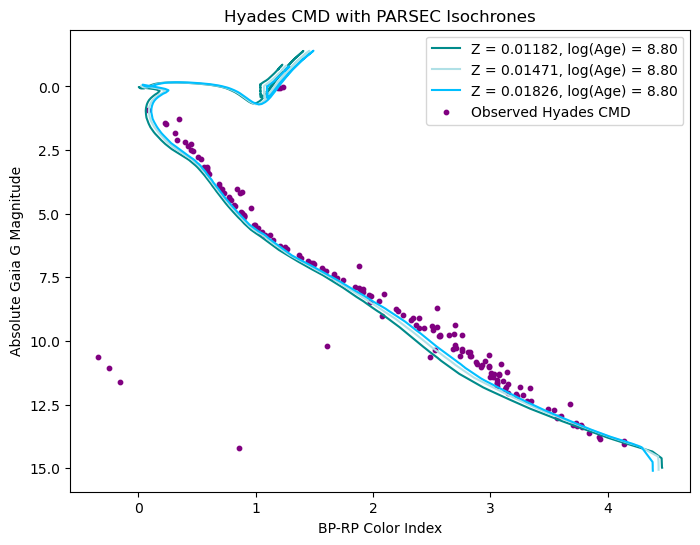

In [323]:
unique_metallicities = hyades_parsec_df['Zini'].unique()[::]  

plt.figure(figsize=(8, 6))

colors = ['darkcyan', 'powderblue', 'deepskyblue']  

for i, metallicity in enumerate(unique_metallicities[:len(colors)]):  
    # Subset the dataframe for the current metallicity
    metallicity_iso = hyades_parsec_df[hyades_parsec_df['Zini'] == metallicity]
    best_age = 8.8 
    age_iso = metallicity_iso[metallicity_iso['logAge'] == best_age]
    
    iso_bp_rp = age_iso['G_BP_fSBmag'] - age_iso['G_RP_fSBmag']
    iso_gaia_g = age_iso['G_fSBmag']
    
    plt.plot(iso_bp_rp, iso_gaia_g, color=colors[i], label=f'Z = {metallicity:.5f}, log(Age) = {best_age:.2f}')

plt.scatter(filtered_hyades_df['bp_rp'], filtered_hyades_df['abs_mag'], s=10, color='purple', label='Observed Hyades CMD')

plt.gca().invert_yaxis()

plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('Hyades CMD with PARSEC Isochrones')
plt.legend()

plt.show()


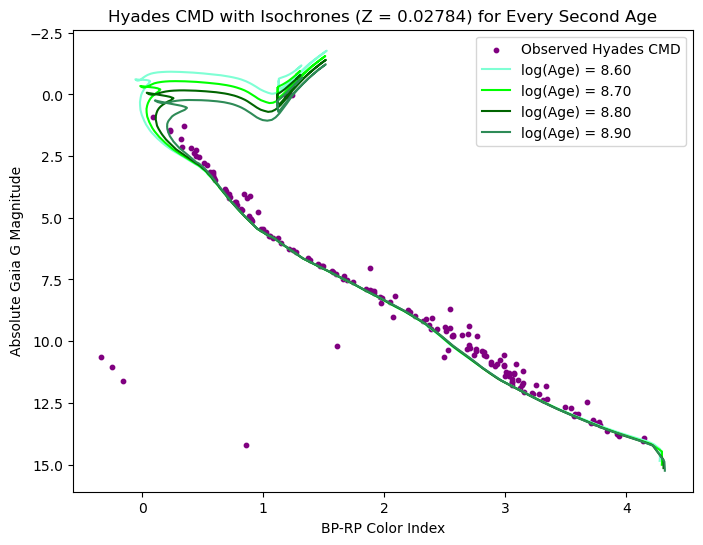

In [320]:
selected_metallicity = 0.02784
tolerance = 0.0005  # Define a small tolerance range

# Subset the dataframe for metallicity within the range [Zini - tolerance, Zini + tolerance]
metallicity_iso = hyades_parsec_df[(hyades_parsec_df['Zini'] >= selected_metallicity - tolerance) & 
                                   (hyades_parsec_df['Zini'] <= selected_metallicity + tolerance)]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_hyades_df['bp_rp'], filtered_hyades_df['abs_mag'], s=10, color='purple', label='Observed Hyades CMD')

unique_ages = metallicity_iso['logAge'].unique()[::2]  # Select every second age

colors = ['aquamarine', 'lime', 'darkgreen', 'seagreen']

# Plot isochrones for each selected age
for i, age in enumerate(unique_ages[:len(colors)]):  # Limiting the number of colors
    # Subset the dataframe for the current age
    age_iso = metallicity_iso[metallicity_iso['logAge'] == age]
    
    # Extract the BP-RP color and Gaia G magnitude for this age
    iso_bp_rp = age_iso['G_BP_fSBmag'] - age_iso['G_RP_fSBmag']
    iso_gaia_g = age_iso['G_fSBmag']
    
    # Plot the isochrone for the current age
    plt.plot(iso_bp_rp, iso_gaia_g, color=colors[i], label=f'log(Age) = {age:.2f}')

plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title(f'Hyades CMD with Isochrones (Z = {selected_metallicity:.5f}) for Every Second Age')
plt.legend()

# Show the plot
plt.show()


We note that Z = 0.02784 corresponds to Fe/H of +0.3, which is the same result as we obtained from the MIST Isochrones. The optimal log(age) is also 8.8 for reasons noted in the MIST discussion.

The most striking observation is that the PARSEC isochrones are not able to accurately obtain stars that are not on the Main Sequence. The several observations towards the bottom-left of the graph are not within the isochrone, and there doesn't seem to be any attempt to include them either. That being said, the PARSEC isochrones certainly follow the observations that exist on the Main Sequence much closer than the MIST isochrones. The local structure is preserved, esepcially in the region between the BP-RP Color Index of 0.5 and 2. In effect, the two observations are part of the same umbrella – it seems as though the PARSEC Isochrones are suitable for discerning local structures, while the MIST Isochrones are suitable for global structures. 

---

In [325]:
file_path = 'm67_PARSEC.txt'
m67_parsec_df = pd.read_csv(file_path, sep='\s+', comment='#', header=None)
if len(m67_parsec_df.columns) == len(column_names):
    m67_parsec_df.columns = column_names
else:
    print(f"Warning: The file has {len(m67_parsec_df.columns)} columns, but {len(column_names)} were provided.")

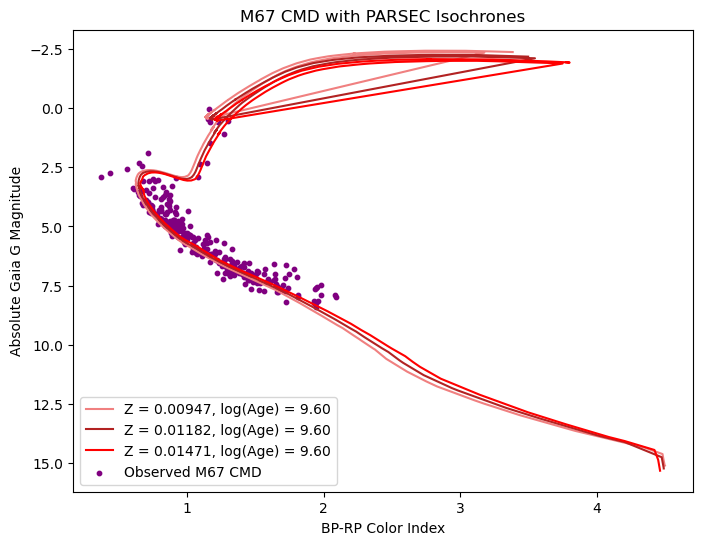

In [321]:
unique_metallicities = m67_parsec_df['Zini'].unique()[:]  

plt.figure(figsize=(8, 6))

colors = ['lightcoral', 'firebrick', 'red'] 

for i, metallicity in enumerate(unique_metallicities[:len(colors)]):
    metallicity_iso = m67_parsec_df[m67_parsec_df['Zini'] == metallicity]
    best_age = 9.6 
    age_iso = metallicity_iso[metallicity_iso['logAge'] == best_age]
    
    iso_bp_rp = age_iso['G_BP_fSBmag'] - age_iso['G_RP_fSBmag']
    iso_gaia_g = age_iso['G_fSBmag']
    
    plt.plot(iso_bp_rp, iso_gaia_g, color=colors[i], label=f'Z = {metallicity:.5f}, log(Age) = {best_age:.2f}')

plt.scatter(filtered_m67_df['bp_rp'], filtered_m67_df['abs_mag'], s=10, color='purple', label='Observed M67 CMD')

plt.gca().invert_yaxis()

plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('M67 CMD with PARSEC Isochrones')
plt.legend()

plt.show()


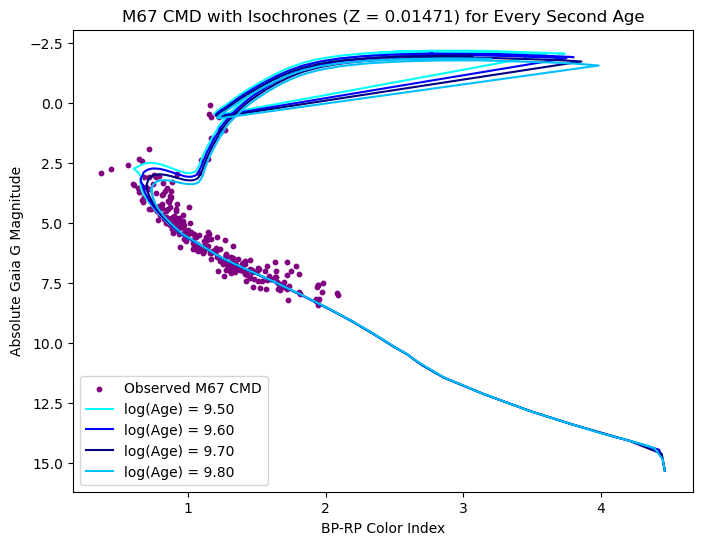

In [324]:
selected_metallicity = 0.01471
tolerance = 0.0005 

# Subset the dataframe for metallicity within the range [Zini - tolerance, Zini + tolerance]
metallicity_iso = m67_parsec_df[(m67_parsec_df['Zini'] >= selected_metallicity - tolerance) & 
                                   (m67_parsec_df['Zini'] <= selected_metallicity + tolerance)]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_m67_df['bp_rp'], filtered_m67_df['abs_mag'], s=10, color='purple', label='Observed M67 CMD')

unique_ages = metallicity_iso['logAge'].unique()[::2]  

colors = ['cyan', 'blue', 'navy', 'deepskyblue']

# Plot isochrones for each selected age
for i, age in enumerate(unique_ages[:len(colors)]):  
    age_iso = metallicity_iso[metallicity_iso['logAge'] == age]
    
    iso_bp_rp = age_iso['G_BP_fSBmag'] - age_iso['G_RP_fSBmag']
    iso_gaia_g = age_iso['G_fSBmag']
    
    plt.plot(iso_bp_rp, iso_gaia_g, color=colors[i], label=f'log(Age) = {age:.2f}')

plt.gca().invert_yaxis()

plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title(f'M67 CMD with Isochrones (Z = {selected_metallicity:.5f}) for Every Second Age')
plt.legend()

# Show the plot
plt.show()


---

In [330]:
file_path = 'ngc6397_PARSEC.txt'
ngc6397_parsec_df = pd.read_csv(file_path, sep='\s+', comment='#', header=None)
if len(m67_parsec_df.columns) == len(column_names):
    ngc6397_parsec_df.columns = column_names
else:
    print(f"Warning: The file has {len(ngc6397_parsec_df.columns)} columns, but {len(column_names)} were provided.")

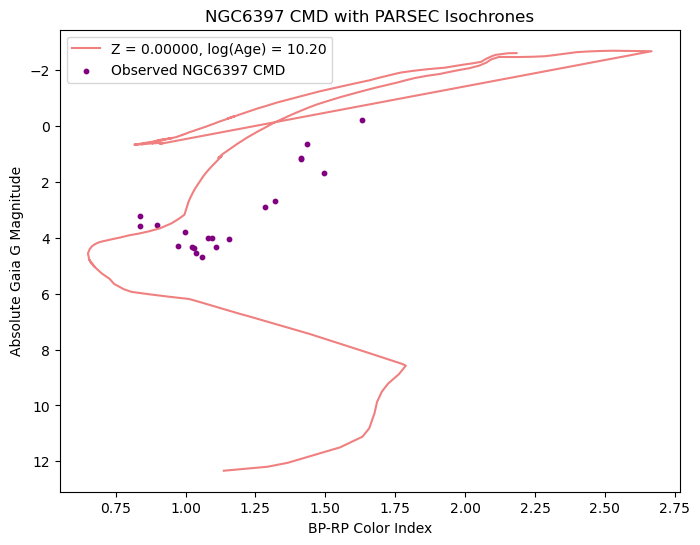

In [331]:
import matplotlib.pyplot as plt
import numpy as np

unique_metallicities = ngc6397_parsec_df['Zini'].unique()[:] 
plt.figure(figsize=(8, 6))
colors = ['lightcoral', 'firebrick', 'red']

for i, metallicity in enumerate(unique_metallicities[:len(colors)]): 
    metallicity_iso = ngc6397_parsec_df[ngc6397_parsec_df['Zini'] == metallicity]
    best_age = 10.2  
    age_iso = metallicity_iso[metallicity_iso['logAge'] == best_age]
    iso_bp_rp = age_iso['G_BP_fSBmag'] - age_iso['G_RP_fSBmag']
    iso_gaia_g = age_iso['G_fSBmag']
    plt.plot(iso_bp_rp, iso_gaia_g, color=colors[i], label=f'Z = {metallicity:.5f}, log(Age) = {best_age:.2f}')

plt.scatter(filtered_ngc6397_df['bp_rp'], filtered_ngc6397_df['abs_mag'], s=10, color='purple', label='Observed NGC6397 CMD')

plt.gca().invert_yaxis()
plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title('NGC6397 CMD with PARSEC Isochrones')
plt.legend()
plt.show()


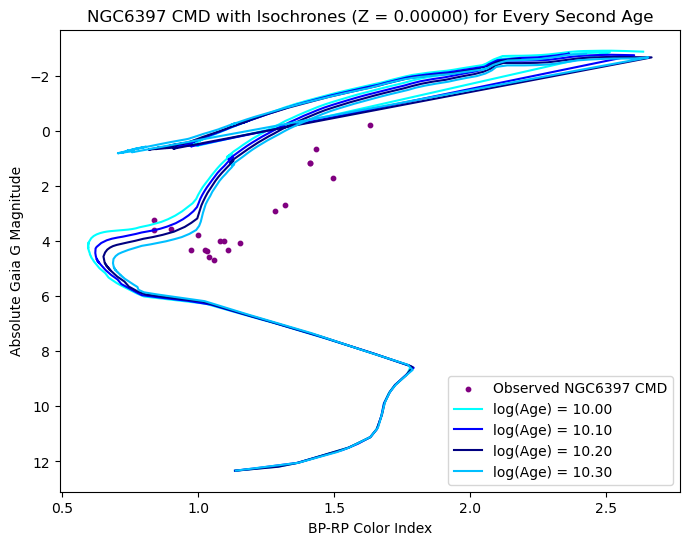

In [333]:
selected_metallicity = 0.0
tolerance = 0.0005 

# Subset the dataframe for metallicity within the range [Zini - tolerance, Zini + tolerance]
metallicity_iso = ngc6397_parsec_df[(ngc6397_parsec_df['Zini'] >= selected_metallicity - tolerance) & 
                                   (ngc6397_parsec_df['Zini'] <= selected_metallicity + tolerance)]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_ngc6397_df['bp_rp'], filtered_ngc6397_df['abs_mag'], s=10, color='purple', label='Observed NGC6397 CMD')

unique_ages = metallicity_iso['logAge'].unique()[::2]  

colors = ['cyan', 'blue', 'navy', 'deepskyblue']

# Plot isochrones for each selected age
for i, age in enumerate(unique_ages[:len(colors)]):  
    age_iso = metallicity_iso[metallicity_iso['logAge'] == age]
    
    iso_bp_rp = age_iso['G_BP_fSBmag'] - age_iso['G_RP_fSBmag']
    iso_gaia_g = age_iso['G_fSBmag']
    
    plt.plot(iso_bp_rp, iso_gaia_g, color=colors[i], label=f'log(Age) = {age:.2f}')

plt.gca().invert_yaxis()

plt.xlabel('BP-RP Color Index')
plt.ylabel('Absolute Gaia G Magnitude')
plt.title(f'NGC6397 CMD with Isochrones (Z = {selected_metallicity:.5f}) for Every Second Age')
plt.legend()

# Show the plot
plt.show()


There is a clear discrepancy between the theory and the data here. While some structure is preserved, for the age of the globular NGC 6397 cluster, the PARSEC Isochrones yield only a visual transaltion of the actual distribution.